# PMR3508 Aprendizado de Máquina e Reconhecimento de Padrões
                                     Base HouseholdIncome - Classificador kNN

* Autor: PMR3508-2019-42

Imports necessários:

In [1]:
# Manipulação dos dados
import pandas as pd
import numpy as np

# Visualização 
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Técnica de Machine Learning
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [79]:
os.listdir("../HouseholdIncome/Kaggle")

['sample_submission.csv', 'test.csv', 'train.csv']

### 1 - Entendendo os dados

Determinação das bases

In [80]:
train = pd.read_csv("../HouseholdIncome/Kaggle/train.csv")
test = pd.read_csv("../HouseholdIncome/Kaggle/test.csv")

train.info()

train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_279628684  190000.0       0      3       0     1       1     0    NaN   
1  ID_f29eb3ddd  135000.0       0      4       0     1       1     1    1.0   
2  ID_68de51c94       NaN       0      8       0     1       1     0    NaN   
3  ID_d671db89c  180000.0       0      5       0     1       1     1    1.0   
4  ID_d56d6f5f5  180000.0       0      5       0     1       1     1    1.0   

   r4h1  ...  SQBescolari  SQBage  SQBhogar_total  SQBedjefe  SQBhogar_nin  \
0     0  ...          100    1849               1        100             0   
1     0  ...          144    4489               1        144             0   
2     0  ...          121    8464               1          0             0   
3     0  ...           81     289              16        121             4   
4     0  ...          121    1369              16        121             4   

   SQBovercrowding  SQBdependency  SQBmeaned  agesq  Target  
0         1.000000            0.0      100.0   1849       4  
1         1.000000           64.0      144.0   4489       4  
2         0.250000           64.0      121.0   8464       4  
3         1.777778            1.0      121.0    289       4  
4         1.777778            1.0      121.0   1369       4  

[5 rows x 143 columns]

In [81]:
test.info()

test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_2f6873615       NaN       0      5       0     1       1     0    NaN   
1  ID_1c78846d2       NaN       0      5       0     1       1     0    NaN   
2  ID_e5442cf6a       NaN       0      5       0     1       1     0    NaN   
3  ID_a8db26a79       NaN       0     14       0     1       1     1    1.0   
4  ID_a62966799  175000.0       0      4       0     1       1     1    1.0   

   r4h1  ...  age  SQBescolari  SQBage  SQBhogar_total  SQBedjefe  \
0     1  ...    4            0      16               9          0   
1     1  ...   41          256    1681               9          0   
2     1  ...   41          289    1681               9          0   
3     0  ...   59          256    3481               1        256   
4     0  ...   18          121     324               1          0   

   SQBhogar_nin  SQBovercrowding  SQBdependency  SQBmeaned  agesq  
0             1             2.25           0.25     272.25     16  
1             1             2.25           0.25     272.25   1681  
2             1             2.25           0.25     272.25   1681  
3             0             1.00           0.00     256.00   3481  
4             1             0.25          64.00        NaN    324  

[5 rows x 142 columns]

Tradução dos rótulos

* 1 = extreme poverty 
* 2 = moderate poverty 
* 3 = vulnerable households 
* 4 = non vulnerable households

Tipos de dados

* Dados Int: certamente se referem às features binárias
* Dados floats: referem-se às variáveis contínuas 
* Dados object: não serão usados devido a dificuldade em trabalhar com machine learning

Análise da distribuição das variáveis contínuas conforme o rótulo

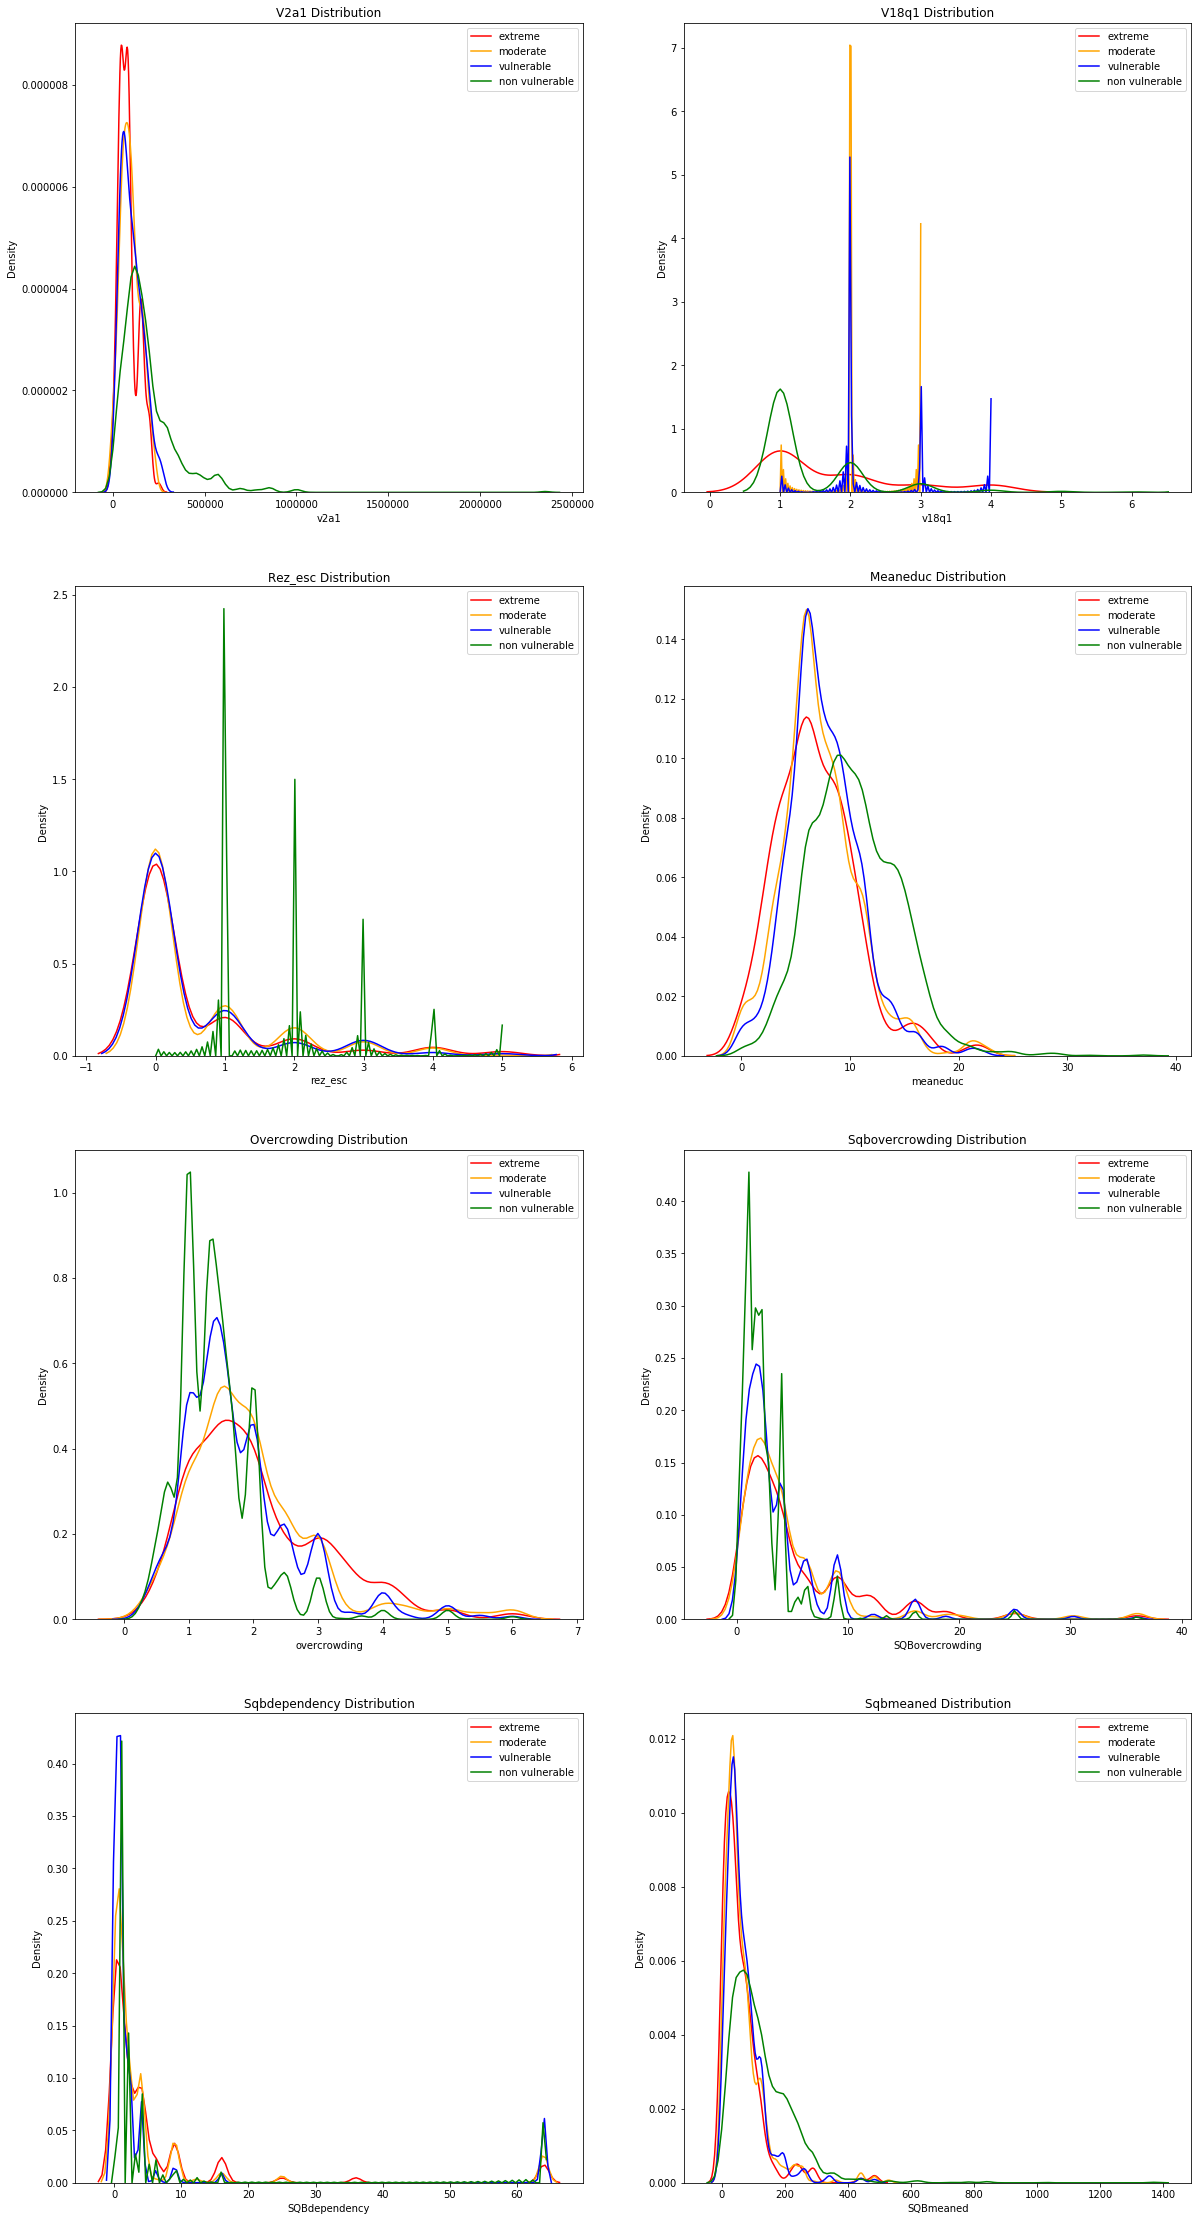

In [82]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))

cores = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
pobreza = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    
    for nivel, cor in cores.items():
       
        sns.kdeplot(train.loc[train['Target'] == nivel, col].dropna(), 
                    ax = ax, color = cor, label = pobreza[nivel])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
    
    plt.subplots_adjust(top = 2)

Como a feature "parentesco1" indica o chefe da família, que reprenta toda a família e assim está diretamente relacionado ao rótulo, passa a ser interessante saber a distribuição dos rótulos.

1     222
2     442
3     355
4    1954
Name: Target, dtype: int64

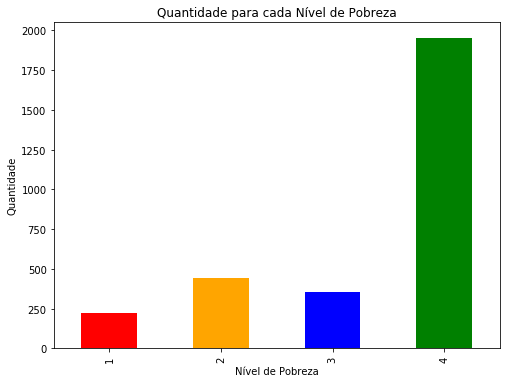

In [83]:
rotulos = train.loc[(train['Target'].notnull()) & (train['parentesco1'] == 1), ['Target', 'idhogar']]

quantidade = rotulos['Target'].value_counts().sort_index()

quantidade.plot.bar(figsize = (8, 6), color = cores.values())

plt.xlabel('Nível de Pobreza')
plt.ylabel('Quantidade')
plt.title('Quantidade para cada Nível de Pobreza')


quantidade

Há mais famílias em situação de não vulnerabilidade (rótulo 4).

Tal distribuição pode representar um problema, já que em média podemos afirmar que a população da Costa Rica não está em vulnerabilidade, o que de fato é verdade pela distribuição, mas tal configuração pode atrapalhar a classificação do modelo de machine learning

##### Identificando erros

Devido ao problema de distribuição talvez pessoas da mesma família tenham rótulos diferentes, então é necessário verificar tal situação

In [84]:
igualdade = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

desigualdade = igualdade[igualdade != True]

print('Há {} famílias com membros de rótulos diferentes'.format(len(desigualdade)))

Há 85 famílias com membros de rótulos diferentes


A partir do resultado é conveniente padronizar a família pelo rótulo do chefe, mas como a acurácia será medida somente em relação ao chefe, então não será necessário

##### Limpeza dos dados

In [85]:
colunas_nulas = train.isnull().sum().sort_values(ascending = False)

porcentagem = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending = False)

faltantes = pd.concat([colunas_nulas, porcentagem], axis = 1, keys = ['Total', '%'])
faltantes.head()

Total          %
rez_esc     7928  82.954902
v18q1       7342  76.823271
v2a1        6860  71.779847
meaneduc       5   0.052318
SQBmeaned      5   0.052318

* v2a1 - Pagamento mensal de aluguel

Tal atributo se relaciona diretamente com a distribuição de 'tipovivi1' que refere-se a quem tem a casa própria e totalmente paga. A estratégia então é preencher com zero o valor da renda mensal de quem possui a casa totalmente paga

Para os demais dados faltantes a alternativa será retirar os dados

In [86]:
train.loc[(train['tipovivi1'] == 1), 'v2a1'] = 0

print('Ainda restam {} dados faltantes para v2a1'.format(train['v2a1'].isnull().sum()))

Ainda restam 949 dados faltantes para v2a1


* rez_esc - Anos atrasado na escola

Tal atributo se relaciona com a idade do indivíduo, então é interessante analisar os dados faltantes de acordo com a idade

In [87]:
train.loc[train['rez_esc'].notnull()]['age'].describe()

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [88]:
train.loc[train['rez_esc'].isnull()]['age'].describe()

count    7928.000000
mean       38.833249
std        20.989486
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64

A maioria dos dados faltantes se relacionam com adultos, enquanto os dados presentes se relacionam com os jovens, no caso de no máximo 17 anos.
Na descrição da base é possível verificar que 'rez_esc' é definida apenas para indivíduos entre 7 e 19 anos, logo, é conveniente zerar o atributo dos dados faltantes dos indivíduos fora da faixa de idade.

In [89]:
train.loc[((train['age'] > 19) | (train['age'] < 7)) & (train['rez_esc'].isnull()), 'rez_esc'] = 0

print('Ainda restam {} dados faltantes para v2a1'.format(train['rez_esc'].isnull().sum()))

Ainda restam 350 dados faltantes para v2a1


* v18q1 - Números de tablets que a família possui

Tal atributo é irrelevante pela intuição, então não será tratado

* meaneduc - média de anos de educação para adultos
* SQBmeaned - quadrado da média de anos de educação dos adultos na casa

Será analisado o boxplot de cada atributo

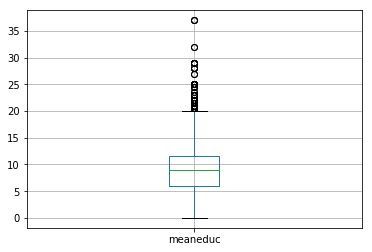

In [90]:
train['meaneduc'].plot(kind = 'box', grid = True)

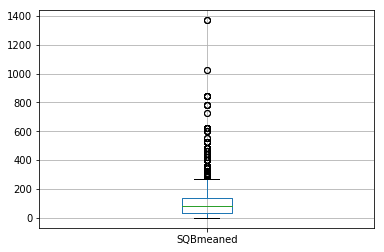

In [91]:
train['SQBmeaned'].plot(kind = 'box', grid = True)

Analisando os box plots, ambos não apresentam tamanha desigualdade, então considerar os dados faltantes como a média da amostra passa a ser uma estratégia interessante.

In [92]:
train['meaneduc'] = train['meaneduc'].fillna(train['meaneduc'].describe().mean())

train['SQBmeaned'] = train['SQBmeaned'].fillna(train['SQBmeaned'].describe().mean())

O restante das linhas com dados faltantes serão eliminadas, mas como 'v18q1' não será levado em consideração na classificação é conveniente filtrar a base pelos atributos relevantes antes do tratamento final dos dados faltantes, como forma de reduzir a quantidade de dados perdidos

##### Seleção dos atributos

A partir da descrição da base optou-se por selecionar as features mais relevantes por intuição:

* v2a1: pagamento mensal do aluguel
* hacdor: superlotação de quartos
* v14a: presença de banheiro a casa
* escolari: anos de escolaridade
* rez_esc: anos atrasado na escola
* hhsize: tamanho da casa
* cielorazo: presença de teto na casa
* abastaguadentro: abastecimento de água dentro da casa
* abastaguano: presença de abastecimento de aágua
* noelec: sem eletricidade na casa
* sanitario1: sem banheiro na casa
* hogar_nin: número de crianças entre 0 e 19 anos na casa
* hogar_total: número total de indivíduos na casa
* meaneduc: média de anos de educação para adultos
* tipovivi1: casa própria e totalmente paga
* area1: zona urbana
* SQBovercrowding: superlotação ao quadrado
* SQBmeaned: quadrado da média de anos de educação dos adultos na casa

In [93]:
atributos = ['v2a1', 'hacdor', 'v14a', 'escolari', 'rez_esc', 'hhsize', 'cielorazo', 'abastaguadentro',
             'abastaguano', 'noelec', 'sanitario1', 'hogar_nin', 'hogar_total', 'meaneduc', 'tipovivi1',
             'area1', 'SQBovercrowding', 'SQBmeaned', 'Target']

# Nova base de dados
base = train[atributos]
base = base.astype(np.float)

print(base.shape)
base.head()

(9557, 19)


v2a1  hacdor  v14a  escolari  rez_esc  hhsize  cielorazo  \
0  190000.0     0.0   1.0      10.0      0.0     1.0        1.0   
1  135000.0     0.0   1.0      12.0      0.0     1.0        1.0   
2       0.0     0.0   1.0      11.0      0.0     1.0        1.0   
3  180000.0     0.0   1.0       9.0      1.0     4.0        1.0   
4  180000.0     0.0   1.0      11.0      0.0     4.0        1.0   

   abastaguadentro  abastaguano  noelec  sanitario1  hogar_nin  hogar_total  \
0              1.0          0.0     0.0         0.0        0.0          1.0   
1              1.0          0.0     0.0         0.0        0.0          1.0   
2              1.0          0.0     0.0         0.0        0.0          1.0   
3              1.0          0.0     0.0         0.0        2.0          4.0   
4              1.0          0.0     0.0         0.0        2.0          4.0   

   meaneduc  tipovivi1  area1  SQBovercrowding  SQBmeaned  Target  
0      10.0        0.0    1.0         1.000000      100.0     4.0  
1      12.0        0.0    1.0         1.000000      144.0     4.0  
2      11.0        1.0    1.0         0.250000      121.0     4.0  
3      11.0        0.0    1.0         1.777778      121.0     4.0  
4      11.0        0.0    1.0         1.777778      121.0     4.0

In [94]:
colunas_nulas = base.isnull().sum().sort_values(ascending = False)

porcentagem = ((base.isnull().sum()/base.isnull().count())*100).sort_values(ascending = False)

faltantes = pd.concat([colunas_nulas, porcentagem], axis = 1, keys = ['Total', '%'])
faltantes.head()

Total         %
v2a1           949  9.929894
rez_esc        350  3.662237
abastaguano      0  0.000000
hacdor           0  0.000000
v14a             0  0.000000

In [95]:
# Retirando os demais dados faltantes

base = base.dropna()
base.shape

(8288, 19)

In [96]:
colunas_nulas = base.isnull().sum().sort_values(ascending = False)

porcentagem = ((base.isnull().sum()/base.isnull().count())*100).sort_values(ascending = False)

faltantes = pd.concat([colunas_nulas, porcentagem], axis = 1, keys = ['Total', '%'])
faltantes.head()

Total    %
Target           0  0.0
abastaguano      0  0.0
hacdor           0  0.0
v14a             0  0.0
escolari         0  0.0

### 2 - Classificador k-NN

In [97]:
# Treino

x_train = base.drop('Target', axis = 1)

y_train = base['Target']

#### Seleção do hiperparâmetro k por Validação Cruzada

In [98]:
inf = 1
sup = 50

scores_media = []
aux = 0
k_max = 0

i = 0
for k in range(inf, sup):
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, x_train, y_train, cv=10)
    scores_media.append(scores.mean())
    
    if scores_media[i] > aux:
        k_max = k
        aux = scores_media[i]
        
    i = i + 1
    
print(k_max)

48


Text(0.5, 1.0, 'Perfomance do algoritmo conforme o valor de k')

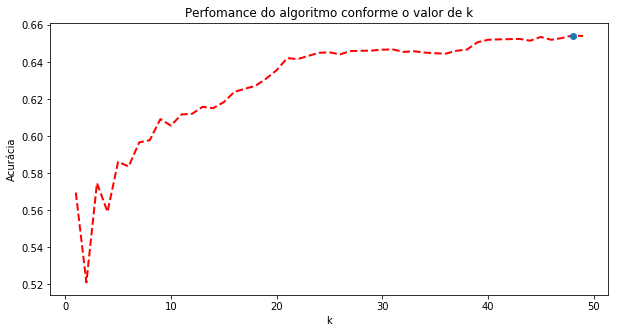

In [99]:
x = np.arange(1, sup)

plt.figure(figsize=(10, 5))
plt.plot(x, scores_media, '--', color = 'red', linewidth = 2)
plt.plot(k_max, scores_media[k_max], 'o')

plt.xlabel('k')
plt.ylabel('Acurácia')
plt.title('Perfomance do algoritmo conforme o valor de k')

In [100]:
print('Acurácia para k = {0} : {1:2.2f}%'.format(k_max, 100 * scores_media[k_max]))

Acurácia para k = 48 : 65.42%


No gráfico acima pode-se observar a acurácia obtida através da validação cruzada conforme o valor de k.